# xGBoost model for tHq background

Run few experiments and save the params in gitlab's ml-experiment.
To load them one should 'connect' to the gitlab ,odel experiment tracking system

In [1]:
import os
from dotenv import load_dotenv
from mlflow import MlflowClient

# Load environment variables from .env file
load_dotenv()

# Verify environment variables are loaded
print(f"MLFLOW_TRACKING_URI: {os.getenv('MLFLOW_TRACKING_URI')}")
print(f"MLFLOW_TRACKING_TOKEN: {'*' * 20 if os.getenv('MLFLOW_TRACKING_TOKEN') else 'Not set'}")

MLFLOW_TRACKING_URI: https://gitlab.cern.ch/api/v4/projects/222677/ml/mlflow/
MLFLOW_TRACKING_TOKEN: ********************


In [2]:

import mlflow


client = MlflowClient()

experiment = mlflow.get_experiment_by_name("xgboost-tHq-bkg")
experiment_id = experiment.experiment_id

mlflow.set_experiment(experiment_id=experiment_id);

## Get the run for the classifier

In [3]:
run_id = "6241f8d0-0539-49aa-b20e-b36d089c0366"
run = client.get_run(run_id)

In [4]:
params = { k: int(v) if v.isdigit() else v for k, v in run.data.params.items() }
params.pop("eval_metric", None)  # Remove eval_metric to avoid conflicts during prediction
params["eval_metric"] = ["logloss", "auc"]
params

{'n_estimators': 2000,
 'max_depth': 2,
 'learning_rate': '0.05',
 'random_state': 42,
 'early_stopping_rounds': 100,
 'eval_metric': ['logloss', 'auc']}

## Load the DATA

In [5]:
import uproot

t_sig = uproot.open("../data/BDT_tree_M800_14TeV.root:BbH_tree")
t_bkg = uproot.open("../data/BKG_tree_tHq_14TeV.root:BbH_tree")

df_sig = t_sig.arrays(library="pd")
df_bkg = t_bkg.arrays(library="pd")

w_sig = df_sig["evt_weight"]
w_bkg = df_bkg["evt_weight"]

In [6]:
# Convert multiplicity columns to integers
df_sig = df_sig.astype({
    'n_bjet': 'int32',
    'n_jets': 'int32',
    'n_fjet': 'int32',
},)
df_bkg = df_bkg.astype({
    'n_bjet': 'int32',
    'n_jets': 'int32',
    'n_fjet': 'int32',
},)

## Inputs preparation

In [7]:
from b2bH_vlq import get_variable_group_names, get_variables_by_group
from hepkit.classification.preprocessing import prepare_training_data, split_train_test_by_unique_id

all_vars = {}
for gr in get_variable_group_names():
    all_vars.update(get_variables_by_group(gr))
all_vars.keys()

dict_keys(['VLQ_pt', 'VLQ_eta', 'VLQ_phi', 'photon1_pt', 'photon1_phi', 'photon1_y', 'photon1_eta', 'photon2_pt', 'photon2_phi', 'photon2_y', 'photon2_eta', 'diphoton_pt', 'diphoton_phi', 'diphoton_y', 'diphoton_eta', 'bjet_pt', 'bjet_phi', 'bjet_y', 'bjet_eta', 'bjet2_pt', 'bjet2_phi', 'bjet2_y', 'bjet2_eta', 'forward_jet_pt', 'forward_jet_phi', 'forward_jet_y', 'forward_jet_eta', 'HT', 'bjet_multiplicity', 'jet_multiplicity', 'forwardjet_multiplicity', 'deltaR_bjet_Higgs', 'VLQ_mass', 'diphoton_mass'])

In [8]:
from itertools import product

cands = ["photon1", "photon2", "diphoton", "bjet", "VLQ"]
obs = ["pt", "eta"]

mva_vars = { }
for cand, obs in product(cands, obs):
    key = f"{cand}_{obs}"
    mva_vars[key] = all_vars[key]
mva_vars["HT"] = all_vars["HT"]
mva_vars["deltaR_bjet_Higgs"] = all_vars["deltaR_bjet_Higgs"]
mva_vars.keys();

In [9]:
Xy, ids = prepare_training_data(
    df_sig,
    df_bkg,
    mva_vars.values(),
    mva_vars.values(),
    sig_weights=w_sig,
    bkg_weights=w_bkg,
    id_columns=["NEvts"]
)

In [10]:
train_set, test_set = split_train_test_by_unique_id(
    Xy, ids, test_ratio=0.2, id_columns=["NEvts"], 
)

train_X = train_set.drop("label", axis=1)
train_y = train_set["label"]

test_X = test_set.drop("label", axis=1)
test_y = test_set["label"]


train_weights = train_X.pop("weights")
test_weights = test_X.pop("weights")

In [11]:
# train_X.head()

## Train model with more data

During experiment train set was further split into a train and a validation set, here re-training using whole training data set.

In [12]:
import xgboost as xgb

In [13]:
model= xgb.XGBClassifier(**params)

model.fit(train_X, train_y, eval_set=[(train_X, train_y), (test_X, test_y)], verbose=100)

[0]	validation_0-logloss:0.63678	validation_0-auc:0.94755	validation_1-logloss:0.63962	validation_1-auc:0.94843
[100]	validation_0-logloss:0.18929	validation_0-auc:0.97622	validation_1-logloss:0.18728	validation_1-auc:0.97630
[200]	validation_0-logloss:0.17924	validation_0-auc:0.97814	validation_1-logloss:0.17940	validation_1-auc:0.97742
[300]	validation_0-logloss:0.17571	validation_0-auc:0.97902	validation_1-logloss:0.17743	validation_1-auc:0.97791
[400]	validation_0-logloss:0.17292	validation_0-auc:0.97971	validation_1-logloss:0.17612	validation_1-auc:0.97820
[500]	validation_0-logloss:0.17078	validation_0-auc:0.98028	validation_1-logloss:0.17530	validation_1-auc:0.97843
[600]	validation_0-logloss:0.16847	validation_0-auc:0.98085	validation_1-logloss:0.17391	validation_1-auc:0.97872
[700]	validation_0-logloss:0.16660	validation_0-auc:0.98132	validation_1-logloss:0.17304	validation_1-auc:0.97893
[800]	validation_0-logloss:0.16501	validation_0-auc:0.98171	validation_1-logloss:0.17265	v

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,100
,enable_categorical,False
,eval_metric,"['logloss', 'auc']"


In [14]:
import matplotlib.pyplot as plt
from hepkit.classification.visualization import (
    plot_train_test_response,
    plot_signal_efficiency_vs_background_rejection,
    plot_roc_auc,
)

In [15]:
train_predict_xgb = model.predict(train_X)
train_proba_xgb = model.predict_proba(train_X) # these are the scores
test_predict_xgb = model.predict(test_X)
test_proba_xgb = model.predict_proba(test_X) # these are the scores

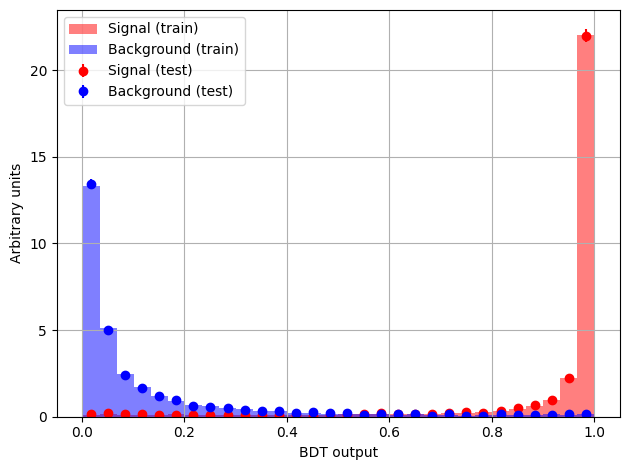

In [16]:
plot_train_test_response(
    model,
    train_X, train_y, test_X, test_y, log_y=False
)
plt.tight_layout()
#plot_filename = "train_test_response.png"
#plt.savefig(plot_filename)
#plt.close()


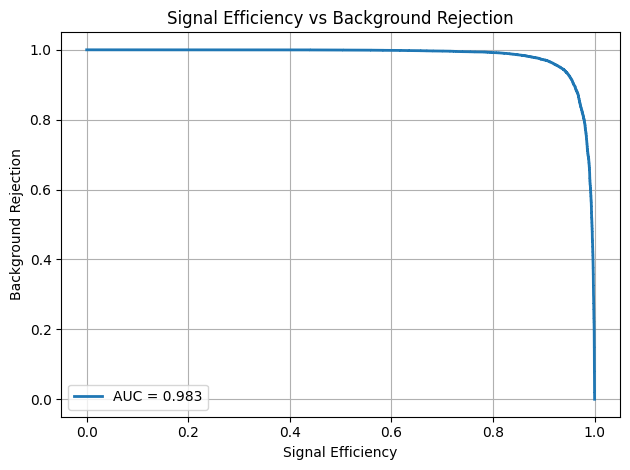

In [17]:
plot_signal_efficiency_vs_background_rejection(train_y, train_proba_xgb[:, 1])
plt.tight_layout()
#plot_filename = "signal_efficiency_vs_background_rejection.png"
#plt.savefig(plot_filename)
#plt.close()